<h1>Notebook for Training, Evaluation and Inference on EfficientDet-D1 using TensorFlow Object Detection API </h1>

<strong><u>Notes</strong></u>:
1. Last checked compatible TensorFlow version: 2.10.0
2. There might be compatibility issues with other packages if TensorFlow deprecates certain functions in future releases. Please update accordingly.
3. Image Preprocessing: TensorFlow Object Detection API takes input in the form of TFRecords. This step is not included in this Notebook and has to be performed separately. We used Roboflow for this purpose.
4. To train or evaluate the model using older checkpoints, just change the "model_checkpoint_path" in the "checkpoint" file to the name of the checkpoint you want to use.
5. Input size = 640x640

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=False)

Mounted at /content/drive


#Cloning TF models repo

In [ ]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models
  

Cloning into 'models'...
remote: Enumerating objects: 3482, done.
remote: Counting objects: 100% (3482/3482), done.
remote: Compressing objects: 100% (2910/2910), done.
remote: Total 3482 (delta 905), reused 1491 (delta 519), pack-reused 0
Receiving objects: 100% (3482/3482), 46.91 MiB | 29.65 MiB/s, done.
Resolving deltas: 100% (905/905), done.


#Compiling Protos and Installing TF Object Detection API

In [ ]:
%%bash
cd models/research
# Compile protos.
protoc object_detection/protos/*.proto --python_out=.
# Install TensorFlow Object Detection API.
cp object_detection/packages/tf2/setup.py .
python -m pip install --use-feature=2020-resolver .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1696118 sha256=7f136f14d3d23a45a22c41bcdf22797dce41ca8e47f87bc5611badfc0e14031a
  Stored in directory: /tmp/pip-ephem-wheel-cache-tef0_u2z/wheels/fa/a4/d2/e9a5057e414fd46c8e543d2706cd836d64e1fcd9eccceb2329
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256=5f3011a5527a7f06a0f3fa64b2cab30950549438c79019ccdadd04864256436e
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78544 sha256=18da317ad60fd7e5994be04539e8327ab59e7c869cab9dd5dc7343fbc8159c3a
  Stored in directory: /root/.cache/pip/wheels/a4/61/fd/c57e374e580aa78a45ed78d5859b3a44436af17e22ca53284f
  Created wheel for avro-python3: filename=avro_p

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


In [ ]:
!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib pycocotools tf_slim


import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

Selecting previously unselected package python-bs4.
(Reading database ... 157604 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to unpack .../5-python-html5lib_0.999999999-1_all.deb ...
Unpacking pyt

#Required Imports

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.10.0


In [ ]:
import os
import numpy as np
import random
from PIL import Image
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model
from tensorflow.keras import Model

#Installing the comptabile OpenCV verison

In [ ]:
!pip install "opencv-python-headless<4.3"
import cv2 as cv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.6 MB 1.4 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.5.2.52
    Uninstalling opencv-python-headless-4.5.2.52:
      Successfully uninstalled opencv-python-headless-4.5.2.52
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-models-official 2.10.0 requires opencv-python-headless==4.5.2.52, but you have opencv-python-headless 4.2.0.34 which is incompatible.


In [ ]:
print(cv.__version__)

4.2.0


In [ ]:
import io
import imageio
import glob
import scipy.misc
from six import BytesIO

#Importing Object Detection utilities

In [ ]:
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

#Installing LibcuDNN

In [ ]:
# Check libcudnn8 version
!apt-cache policy libcudnn8

# Install latest version
!apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

# Export env variables
!export PATH=/usr/local/cuda-11.4/bin${PATH:+:${PATH}}
!export LD_LIBRARY_PATH=/usr/local/cuda-11.4/lib64:$LD_LIBRARY_PATH
!export LD_LIBRARY_PATH=/usr/local/cuda-11.4/include:$LD_LIBRARY_PATH
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/local/cuda/extras/CUPTI/lib64

libcudnn8:
  Installed: 8.0.5.39-1+cuda11.1
  Candidate: 8.5.0.96-1+cuda11.7
  Version table:
     8.5.0.96-1+cuda11.7 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.5.0.96-1+cuda10.2 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.4.1.50-1+cuda11.6 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.4.1.50-1+cuda10.2 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.4.0.27-1+cuda11.6 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.4.0.27-1+cuda10.2 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.3.3.40-1+cuda11.5 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.3.3.40-1+cuda10.2

#Paths

In [ ]:
#PLEASE CHANGE PATHS AS REQUIRED

dataset_used = 'Main_dataset_640'
train_record_path = '/content/drive/My Drive/BoneJoints/'+dataset_used+'/train/joints.tfrecord'
model_dir = '/content/drive/MyDrive/BoneJoints/Model_Checkpoints/EfficientDet_D1/Run1_03092022/training'
labelmap_path = '/content/drive/My Drive/BoneJoints/'+dataset_used+'/train/joints_label_map.pbtxt'
valid_record_path = '/content/drive/My Drive/BoneJoints/'+dataset_used+'/test/joints.tfrecord'
default_config_path = '/content/efficientdet_d1_coco17_tpu-32/pipeline.config' 
pipeline_config_path = '/content/drive/MyDrive/BoneJoints/Model_Checkpoints/EfficientDet_D1/Run1_03092022/training/pipeline.config'
checkpoint_path = '/content/checkpoint/ckpt-0'

In [ ]:
!wget "http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d1_coco17_tpu-32.tar.gz"
!tar -xvf efficientdet_d1_coco17_tpu-32.tar.gz

os.makedirs('/content/checkpoint/') #to check
!mv efficientdet_d1_coco17_tpu-32/checkpoint /content/

--2022-09-07 18:11:32--  http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d1_coco17_tpu-32.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.142.128, 2607:f8b0:400e:c08::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.142.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51839363 (49M) [application/x-tar]
Saving to: ‘efficientdet_d1_coco17_tpu-32.tar.gz’

efficientdet_d1_coc 100%[===================>]  49.44M  46.8MB/s    in 1.1s    

2022-09-07 18:11:34 (46.8 MB/s) - ‘efficientdet_d1_coco17_tpu-32.tar.gz’ saved [51839363/51839363]

efficientdet_d1_coco17_tpu-32/
efficientdet_d1_coco17_tpu-32/checkpoint/
efficientdet_d1_coco17_tpu-32/checkpoint/ckpt-0.data-00000-of-00001
efficientdet_d1_coco17_tpu-32/checkpoint/checkpoint
efficientdet_d1_coco17_tpu-32/checkpoint/ckpt-0.index
efficientdet_d1_coco17_tpu-32/pipeline.config
efficientdet_d1_coco17_tpu-32/saved_model/
efficientdet_

#Hyperparameters

In [ ]:
num_classes = 4
batch_size = 8
train_steps = 5000
num_epochs = 40
eval_steps = 1500
optimizer = 'Adam'
learning_rate = 0.003
warmup_lr = 0.0001
num_images = 3413
checkpoint_type = "detection"

In [ ]:
def num_step_calc():
  steps_per_epoch = num_images/batch_size
  num_steps = num_epochs*steps_per_epoch
  return num_steps

train_steps = int(num_step_calc())
print(train_steps)

17065


#Dynamically editing Pipeline Config using Protocol Buffer API

In [ ]:
from google.protobuf import text_format
from object_detection.protos import pipeline_pb2

configs = pipeline_pb2.TrainEvalPipelineConfig()                                                                                                                                                                                                          

with tf.io.gfile.GFile(default_config_path, "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, configs)


configs.model.ssd.num_classes = num_classes
configs.model.ssd.freeze_batchnorm = True

configs.train_config.batch_size = batch_size
configs.train_config.num_steps = train_steps
configs.train_config.fine_tune_checkpoint = checkpoint_path
configs.train_config.fine_tune_checkpoint_type = checkpoint_type

configs.train_config.optimizer.adam_optimizer.learning_rate.cosine_decay_learning_rate.learning_rate_base = learning_rate
configs.train_config.optimizer.adam_optimizer.learning_rate.cosine_decay_learning_rate.total_steps = train_steps
configs.train_config.optimizer.adam_optimizer.learning_rate.cosine_decay_learning_rate.warmup_learning_rate = warmup_lr
configs.train_config.optimizer.adam_optimizer.learning_rate.cosine_decay_learning_rate.warmup_steps = int(3413/batch_size)

configs.train_input_reader.label_map_path = labelmap_path
configs.train_input_reader.tf_record_input_reader.input_path[:] = [train_record_path] 

configs.eval_input_reader[0].label_map_path = labelmap_path
configs.eval_input_reader[0].tf_record_input_reader.input_path[:] = [valid_record_path]

config_text = text_format.MessageToString(configs)                                                                                                                                                                                                        
with tf.io.gfile.GFile(pipeline_config_path, "wb") as f:
  f.write(config_text)

#Training the Model

In [ ]:
!python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_config_path} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={train_steps} \
    --num_eval_steps={eval_steps}

2022-09-07 18:56:25.995022: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I0907 18:56:26.000915 139766533900160 mirrored_strategy.py:374] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: 17065
I0907 18:56:26.009629 139766533900160 config_util.py:552] Maybe overwriting train_steps: 17065
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0907 18:56:26.009849 139766533900160 config_util.py:552] Maybe overwriting use_bfloat16: False
I0907 18:56:26.019223 139766533900160 ssd_efficientnet_bifpn_feature_extractor.py:146] EfficientDet EfficientNet backbone version: efficientnet-b1
I0907 18:56:26.019360 139766533900160 ssd_efficientnet_bifpn_feature_extractor.py:147] 

#Evaluating the Model

## COCO Metrics

In [ ]:
!python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_config_path} \
    --model_dir={model_dir} \
    --checkpoint_dir={model_dir}

2022-09-21 07:15:30.782308: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-21 07:15:31.633970: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2022-09-21 07:15:31.634070: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2022-09-21 07:15:31.634090: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed p

#Visualizing using Tensorboard

##Training visualizer

In [ ]:
%load_ext tensorboard
%tensorboard --logdir '/content/drive/MyDrive/BoneJoints/Model_Checkpoints/EfficientDet_D1/Run1_03092022/training/train'

##Evaluation Visualizer

In [ ]:
%load_ext tensorboard
%tensorboard --logdir '/content/drive/MyDrive/BoneJoints/Model_Checkpoints/EfficientDet_D1/Run1_03092022/training/eval'

#Exporting Inference Graph and saving best model

##Exporting Inference Graph

In [ ]:
output_directory = 'inference_graph'


!python /content/models/research/object_detection/exporter_main_v2.py \
    --trained_checkpoint_dir {model_dir} \
    --output_directory {output_directory} \
    --pipeline_config_path {pipeline_config_path}

2022-09-20 06:19:24.504127: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-20 06:19:25.424676: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2022-09-20 06:19:25.424848: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2022-09-20 06:19:25.424869: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed p

##Creating Saved Model zip

In [ ]:
%%bash
cp /content/drive/MyDrive/BoneJoints/Main_dataset_640/train/joints_label_map.pbtxt /content/inference_graph/saved_model/
zip -r /content/saved_model.zip /content/inference_graph/saved_model/

  adding: content/inference_graph/saved_model/ (stored 0%)
  adding: content/inference_graph/saved_model/joints_label_map.pbtxt (deflated 67%)
  adding: content/inference_graph/saved_model/variables/ (stored 0%)
  adding: content/inference_graph/saved_model/variables/variables.index (deflated 79%)
  adding: content/inference_graph/saved_model/variables/variables.data-00000-of-00001 (deflated 27%)
  adding: content/inference_graph/saved_model/saved_model.pb (deflated 93%)
  adding: content/inference_graph/saved_model/assets/ (stored 0%)


##Copying saved model TO Drive

In [ ]:
!cp -avr /content/saved_model.zip /content/drive/MyDrive/BoneJoints/Model_Checkpoints/EfficientDet_D1/

'/content/saved_model.zip' -> '/content/drive/MyDrive/BoneJoints/Model_Checkpoints/EfficientDet_D1/saved_model.zip'


#Running Inference on Random Images

##Importing Utils

In [ ]:
!wget https://raw.githubusercontent.com/hugozanini/object-detection/master/inferenceutils.py
from inferenceutils import *

--2022-09-23 20:28:55--  https://raw.githubusercontent.com/hugozanini/object-detection/master/inferenceutils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2219 (2.2K) [text/plain]
Saving to: ‘inferenceutils.py’

inferenceutils.py   100%[===================>]   2.17K  --.-KB/s    in 0s      

2022-09-23 20:28:56 (44.3 MB/s) - ‘inferenceutils.py’ saved [2219/2219]



##Coping saved model FROM Drive

In [ ]:
!cp -avr /content/drive/MyDrive/BoneJoints/Model_Checkpoints/EfficientDet_D1/saved_model.zip ./

'/content/drive/MyDrive/BoneJoints/Model_Checkpoints/EfficientDet_D1/saved_model.zip' -> './saved_model.zip'


##Unzipping saved model

In [ ]:
%%bash
unzip ./saved_model.zip

Archive:  /content/saved_model.zip
   creating: content/inference_graph/saved_model/
  inflating: content/inference_graph/saved_model/joints_label_map.pbtxt  
   creating: content/inference_graph/saved_model/variables/
  inflating: content/inference_graph/saved_model/variables/variables.index  
  inflating: content/inference_graph/saved_model/variables/variables.data-00000-of-00001  
  inflating: content/inference_graph/saved_model/saved_model.pb  
   creating: content/inference_graph/saved_model/assets/


##Loading model

In [ ]:
output_directory = 'inference_graph/'
category_index = label_map_util.create_category_index_from_labelmap(labelmap_path, use_display_name=True)
tf.keras.backend.clear_session()
model = tf.saved_model.load(f'/content/{output_directory}/saved_model')

##Running Inference

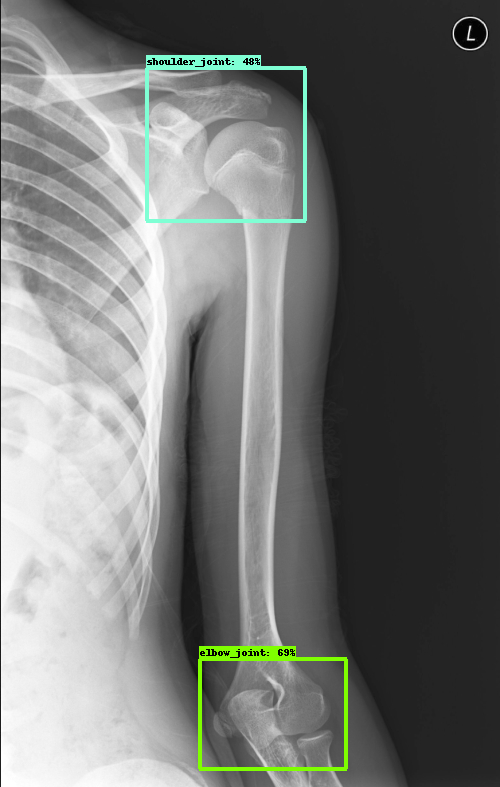

In [ ]:
image_names = [] #Enter links to inference images here
               
num_images = len(image_names)
image_np = load_image_into_numpy_array(image_names[4])
output_dict = run_inference_for_single_image(model, image_np)

vis_util.visualize_boxes_and_labels_on_image_array(
    image_np,
    output_dict['detection_boxes'],
    output_dict['detection_classes'],
    output_dict['detection_scores'],
    category_index,
    instance_masks=output_dict.get('detection_masks_reframed', None),
    use_normalized_coordinates=True,
    min_score_thresh=.4,   #Change minimum confidence threshold
    line_thickness=4)      #Change thickness of bounding boxes edges
display(Image.fromarray(image_np))